In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
from tqdm import tqdm
from multiprocessing import Pool
import numpy.ma as ma
from scipy.ndimage import gaussian_filter, convolve
import sys

sys.path.append("../")
import utils

In [2]:
event_data = np.loadtxt("../data/events.txt")
position_data = np.loadtxt("../data/groundtruth.txt")

In [3]:
#params
t_start = 0.0
duration = 3.4

img_height = 180
img_width = 240

Filter the events for a given time frame

In [4]:
events_range = utils.get_events_range(event_data, t_start, duration)

Select the patch of the events we want to consider

In [5]:
patch_center = (40, 76)
patch_size = 15
x_lim = (patch_center[1] - int(patch_size/2), patch_center[1] + int(patch_size/2))
y_lim = (patch_center[0] - int(patch_size/2), patch_center[0] + int(patch_size/2))
print(x_lim)

events_filtered = events_range
events_filtered = events_filtered[np.logical_and((x_lim[0] <= events_filtered[:,1]) , (events_filtered[:,1] <= x_lim[1]))]
events_filtered = events_filtered[np.logical_and((y_lim[0] <= events_filtered[:,2]) , (events_filtered[:,2] <= y_lim[1]))]
#events_filtered = events_filtered[[(y_lim[0] >= events_range[:,2]) & (events_range[:,2] <= y_lim[1])]
events_filtered = np.array(events_filtered)

(69, 83)


In [6]:
def img_from_events(events):
    img = np.zeros((img_height, img_width))
    for e in events:
        if e[3] == 1:
            continue
        x = int(e[1])
        y = int(e[2])
        img[y, x] += 1
    return img

In [7]:
def img_from_events_patch(events, patch_size):
    img = np.zeros((patch_size, patch_size))
    for e in events:
        if e[3] == 1:
            continue
        x = int(e[1]) - patch_center[1] + int(patch_size/2)
        y = int(e[2]) - patch_center[0] + int(patch_size/2)
        img[y, x] += 1
    return img

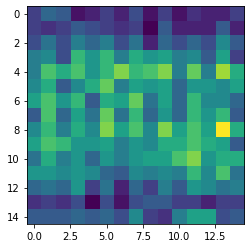

In [8]:
img = img_from_events_patch(events_filtered, patch_size)
plt.imshow(img)

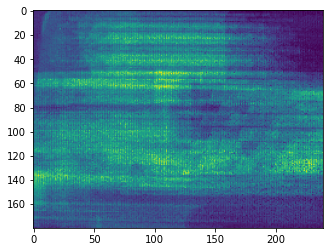

In [9]:
img = np.zeros((180, 240))
for e in events_range:
    if e[3] == 1:
        continue
    x = int(e[1])
    y = int(e[2])
    img[y, x] += 1
plt.imshow(img)

In [10]:
def filter_refactory(events, ref_time):
    time_dict = {}
    result = []
    for e in events:
        key = (e[1], e[2])
        if key not in time_dict:
            time_dict[key] = e[0]
            result.append(e)
            continue
        if e[0] - time_dict[key] > ref_time:
            time_dict[key] = e[0]
            result.append(e)
    return np.array(result)

In [11]:
events_filtered_ref = filter_refactory(events_filtered, 0.04)

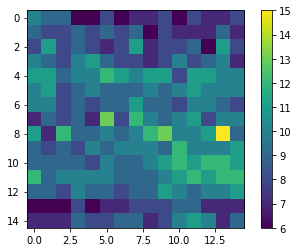

In [12]:
img = img_from_events_patch(events_filtered_ref, patch_size)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m)
plt.colorbar(mappable=m)

In [13]:
events_ref = filter_refactory(events_range, 0.09)

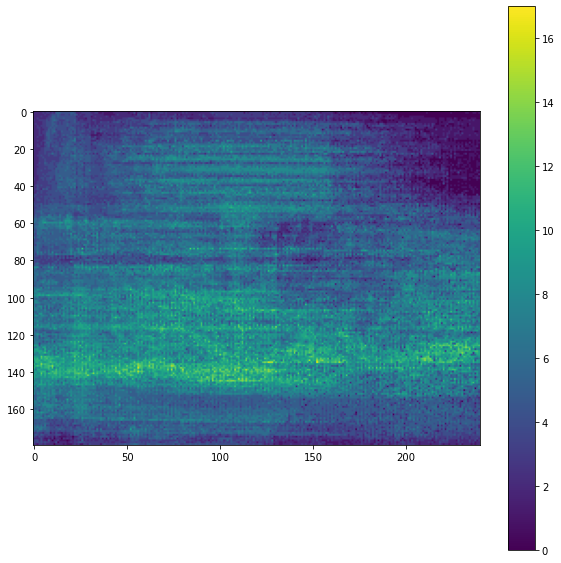

In [14]:
plt.figure(figsize=(10, 10))
img = img_from_events(events_ref)
m = plt.imshow(img)
plt.colorbar(mappable=m)

In [15]:
events_ref

array([[3.811000e-03, 9.600000e+01, 1.330000e+02, 0.000000e+00],
       [3.820001e-03, 1.270000e+02, 1.710000e+02, 0.000000e+00],
       [3.836000e-03, 4.000000e+00, 1.600000e+02, 0.000000e+00],
       ...,
       [2.899988e+00, 7.800000e+01, 1.210000e+02, 0.000000e+00],
       [2.899994e+00, 8.000000e+01, 1.330000e+02, 0.000000e+00],
       [2.899997e+00, 2.100000e+02, 1.350000e+02, 1.000000e+00]])

In [15]:
np.savetxt("../data_processed/events_refact_34s.txt", events_ref)

In [17]:
events_r = events_ref.copy()

In [18]:
test = events_r.copy()
test[:,1:] = events_r[:,1:].astype(int)

In [19]:
# np.savetxt("../data_processed/events_refact.txt", test)

In [20]:
a = np.array([
    [0, 0, 1],
    [1, 0, 1],
    [0, 1, 0]
])
u = np.array([
    [0.5, 1, 0],
    [1, 1, 0.5],
    [0, 1, 1]
])

In [21]:
t = a > np.zeros((3, 3))
t

array([[False, False,  True],
       [ True, False,  True],
       [False,  True, False]])

In [22]:
u[t] = a[t]

In [23]:
u

array([[0.5, 1. , 1. ],
       [1. , 1. , 1. ],
       [0. , 1. , 1. ]])

In [24]:
a = np.array([0, 1, 0, 1, 1, 0])
b = np.array([0.5, 1, 1, 0, 0.5, 0])

In [25]:
t = a > np.array([0, 0, 0, 0, 0, 0])
b[t] = 2

In [26]:
b

array([0.5, 2. , 1. , 2. , 2. , 0. ])

In [50]:
position_data.shape

(11947, 8)

In [51]:
id_pos_start = np.searchsorted(position_data[:,0], t_start)
id_pos_end = np.searchsorted(position_data[:,0], t_start + duration)

In [52]:
position_range = position_data[id_pos_start:id_pos_end,:]

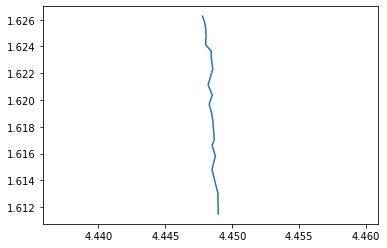

In [57]:
plt.axis("equal")
plt.plot(position_range[:,1], position_range[:,2])